### Imports

In [190]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler, WeightedRandomSampler
import matplotlib.pyplot as plt
from torchsummary import summary
from collections import Counter

torch.cuda.is_available()

True

#### Ambiente

In [191]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Pré-processamento

##### Carregando o dataset

In [192]:
def Create_Data_Loader(dir, train_ratio=0.8, batch_size=32):
  IMG_SIZE = 224

  transformations = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Convertendo para escala de cinza
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
  ])

  data = ImageFolder(dir, transform=transformations)

  dataset_class_counts = [count for _, count in sorted(Counter(data.targets).items())]
  class_counts = {c: 0 for c in data.classes}

  train_indices = []
  test_indices = []

  print("Total imagens: ", len(data))

  for idx, (image, label) in enumerate(data.samples):
    class_name = data.classes[label]

    if class_counts[class_name] < train_ratio * dataset_class_counts[label]:
      train_indices.append(idx)
      class_counts[class_name] += 1
    else:
      test_indices.append(idx)

  print(f'Dataset dividido em Treino: {len(train_indices)} e Teste: {len(test_indices)}')

  train_sampler = SubsetRandomSampler(train_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler)
  test_loader = DataLoader(data, batch_size=batch_size, sampler=test_sampler)
  class_names = data.classes

  train_class_counts = [count for _, count in sorted(Counter(np.array(data.targets)[train_sampler.indices]).items())]
  test_class_counts = [count for _, count in sorted(Counter(np.array(data.targets)[test_sampler.indices]).items())]
  print("Balanceamento das classes no conjunto de treino:", train_class_counts)
  print("Balanceamento das classes no conjunto de teste:", test_class_counts)

  return train_loader, test_loader, class_names

In [193]:
BATCH_SIZE = 16

data_folder = "./data/"
train_loader, test_loader, class_names = Create_Data_Loader(dir=data_folder, batch_size=BATCH_SIZE)

print(f'Classes: {class_names}')

Total imagens:  1196
Dataset dividido em Treino: 958 e Teste: 238
Balanceamento das classes no conjunto de treino: [236, 375, 347]
Balanceamento das classes no conjunto de teste: [59, 93, 86]
Classes: ['covid', 'normal', 'virus']


Text(0.5, 1.0, 'covid')

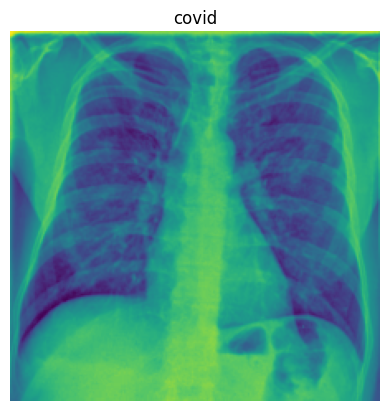

In [194]:
image_batch, label_batch = next(iter(train_loader))
image, label = image_batch[0], label_batch[0]

plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

### Modelagem da CNN

In [195]:
class MyCNN(nn.Module):

    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
    
        self.model = nn.Sequential(
            # Entrada: 1x224x224 (1 canal de cor)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 32x112x112

            # Entrada: 32x112x112
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 64x56x56

            # Entrada: 64x56x56
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 128x28x28

            # Entrada: 128x28x28
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 256x14x14

            nn.Flatten(),

            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),

            # nn.Dropout(0.2),

            nn.Linear(512, num_classes)

        )
    
    def forward(self, x):
        return self.model(x)

In [196]:
summary(MyCNN(num_classes=len(class_names)).to(device), (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
          Flatten-13                [-1, 50176]               0
           Linear-14                  [

In [197]:
model = MyCNN(num_classes=len(class_names)).to(device)

In [198]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

### Treinamento

In [199]:
n_epochs = 100

history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

for epoch in range(n_epochs):
    # Treinamento
    model.train()
    train_loss = 0
    train_acc = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        y_hat = model(images)
        loss = loss_fn(y_hat, labels)
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
        train_acc += (torch.argmax(y_hat, dim=1) == labels).float().sum()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Teste
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            y_hat = model(images)
            loss = loss_fn(y_hat, labels)
            test_loss += float(loss)
            test_acc += (torch.argmax(y_hat, dim=1) == labels).float().sum()
    test_loss /= len(test_loader)
    test_acc /= len(test_loader.dataset)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/100, Train Loss: 12.1784, Train Acc: 0.3018, Test Loss: 1.0831, Test Acc: 0.0778
Epoch 2/100, Train Loss: 1.0825, Train Acc: 0.3043, Test Loss: 1.0835, Test Acc: 0.0778
Epoch 3/100, Train Loss: 1.0849, Train Acc: 0.2968, Test Loss: 1.0826, Test Acc: 0.0778
Epoch 4/100, Train Loss: 1.0819, Train Acc: 0.3135, Test Loss: 1.0815, Test Acc: 0.0778
Epoch 5/100, Train Loss: 1.0833, Train Acc: 0.3135, Test Loss: 1.0818, Test Acc: 0.0778
Epoch 6/100, Train Loss: 1.0819, Train Acc: 0.3135, Test Loss: 1.0815, Test Acc: 0.0778
Epoch 7/100, Train Loss: 1.0814, Train Acc: 0.3135, Test Loss: 1.0813, Test Acc: 0.0778
Epoch 8/100, Train Loss: 1.0821, Train Acc: 0.3135, Test Loss: 1.0805, Test Acc: 0.0778


KeyboardInterrupt: 

### Teste e Resultados